In [36]:
pip install  alpha_vantage

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
import re
from alpha_vantage.timeseries import TimeSeries
from openai import AzureOpenAI
import os

In [38]:
NUM_TRADING_DAYS=252
NUM_PORTFOLIOS = 10000
stocks =[]

start_date='2023-01-01'
end_date='2025-01-01'

In [39]:

def download_data(stocks,start_date,end_date):
    stock_data={}
    for stock in stocks:
        ticker=yf.Ticker(stock)
        stock_data[stock]=ticker.history(start=start_date,end=end_date)['Close']
    return pd.DataFrame(stock_data)



In [40]:
def show_data(data):
  data.plot(figsize=(10,5))
  plt.show()



In [41]:
def calculate_return(data):
  log_returns=np.log(data/data.shift(1))
  return log_returns.iloc[1:]



In [42]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)




In [43]:
def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)

In [44]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [45]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])

In [46]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [47]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [58]:
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)

def print_optimal_portfolio(optimum, returns,weights,stats,tot):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))
    weights=optimum['x'].round(3)
    for stock, weight in zip(stocks, weights):
        print(f"{stock}: {weight*tot}")
    stats=statistics(optimum['x'].round(3), returns)
    print(f"Expected return: {stats[0]}")
    print(f"Expected volatility: {stats[1]}")
    print(f"Sharpe ratio: {stats[2]}")

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


In [50]:
# Alpha Vantage Config
API_KEY = os.getenv('ALPHA_VANTAGE_KEY', 'LMHT2VOXR7FYT4N2')
ts = TimeSeries(key=API_KEY, output_format='pandas')

# Azure OpenAI Config
AZURE_ENDPOINT = os.getenv('AZURE_ENDPOINT', 'https://ai-aihackthonhub282549186415.cognitiveservices.azure.com/')
AZURE_KEY = os.getenv('AZURE_KEY', 'Fj1KPt7grC6bAkNja7daZUstpP8wZTXsV6Zjr2FOxkO7wsBQ5SzQJQQJ99BCACHYHv6XJ3w3AAAAACOGL3Xg')
azure_client = AzureOpenAI(
    azure_endpoint=AZURE_ENDPOINT,
    api_key=AZURE_KEY,
    api_version="2024-05-01-preview"
)

In [57]:

def filter_valid_tickers(tickers):
    valid_tickers = []
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            info = stock.history(period='1d')  # Fetch historical data to check validity
            if not info.empty:  # If data exists, it's a valid ticker
                valid_tickers.append(ticker)
        except Exception as e:
            print(f"Skipping {ticker}: {e}")
    return valid_tickers

In [51]:

def recommend_portfolio(risk_tolerance, investment_goals, personal_preferences, capital):
    """
    Get AI-generated stock recommendations based on user's financial profile.
    
    Args:
        risk_tolerance (str): User's risk tolerance level (e.g., 'Low', 'Medium', 'High')
        investment_goals (str): User's investment objectives
        personal_preferences (str): User's personal investment preferences
        capital (float): Total capital available for investment
        
    Returns:
        list: Recommended stock tickers
    """
    ai_prompt = f"""
    As a financial advisor, recommend specific stock tickers (in **bold** format like **AAPL**) 
    for a portfolio with these characteristics:
    - Risk Tolerance: {risk_tolerance}
    - Investment Goals: {investment_goals}
    - Total Capital: ${capital:,.2f}
    - Personal Preferences: {personal_preferences}
    
    Provide only the tickers in **bold** format, no additional explanations needed.
    """

    try:
        response = azure_client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a concise financial advisor that only responds with stock tickers in **bold** format."},
                {"role": "user", "content": ai_prompt}
            ],
            max_tokens=500,
            temperature=0.7
        ).choices[0].message.content

        print("\n💼 Recommended Portfolio Allocation:\n", response)
        
        # Extract stock symbols using regex (matches text between ** **)
        stocks = re.findall(r'\*\*([A-Z]{1,5})\*\*', response)
        
        print("\n✅ Extracted Stock Tickers:\n", stocks)
        return stocks
        
    except Exception as e:
        print(f"❌ Error in AI recommendation: {str(e)}")
        return []


In [61]:
if __name__ == '__main__':
    risk_tolerance=input()
    investment_goals=input()
    personal_preferences=input()
    capital=float(input())
    stocks = recommend_portfolio(
    risk_tolerance,
    investment_goals,
    personal_preferences,
    capital
)

    print(stocks)


💼 Recommended Portfolio Allocation:
 **TSLA** **NVDA** **AMD** **SQ** **SHOP**

✅ Extracted Stock Tickers:
 ['TSLA', 'NVDA', 'AMD', 'SQ', 'SHOP']
['TSLA', 'NVDA', 'AMD', 'SQ', 'SHOP']


$SQ: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


['TSLA', 'NVDA', 'AMD', 'SHOP']


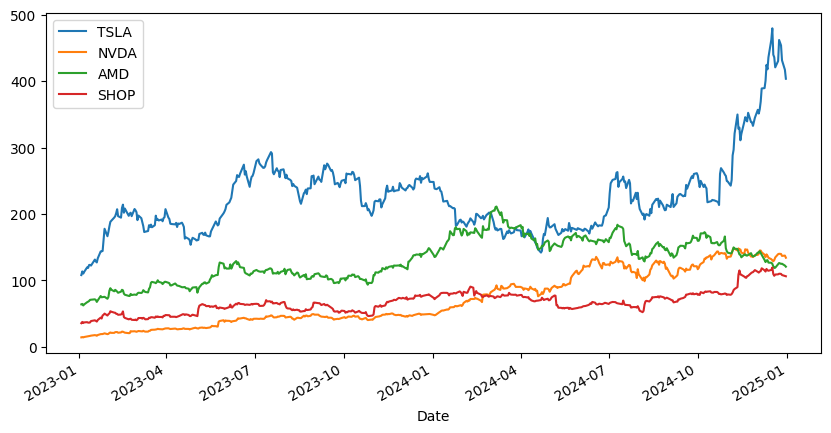

                                 TSLA        NVDA         AMD        SHOP
Date                                                                     
2023-01-03 00:00:00-05:00  108.099998   14.303279   64.019997   35.680000
2023-01-04 00:00:00-05:00  113.639999   14.736922   64.660004   37.540001
2023-01-05 00:00:00-05:00  110.339996   14.253322   62.330002   35.950001
2023-01-06 00:00:00-05:00  113.059998   14.846835   63.959999   36.849998
2023-01-09 00:00:00-05:00  119.769997   15.615205   67.239998   37.189999
...                               ...         ...         ...         ...
2024-12-24 00:00:00-05:00  462.279999  140.207108  126.290001  110.180000
2024-12-26 00:00:00-05:00  454.130005  139.917130  125.059998  109.959999
2024-12-27 00:00:00-05:00  431.660004  136.997391  125.190002  108.180000
2024-12-30 00:00:00-05:00  417.410004  137.477356  122.440002  106.690002
2024-12-31 00:00:00-05:00  403.839996  134.277649  120.790001  106.330002

[502 rows x 4 columns]


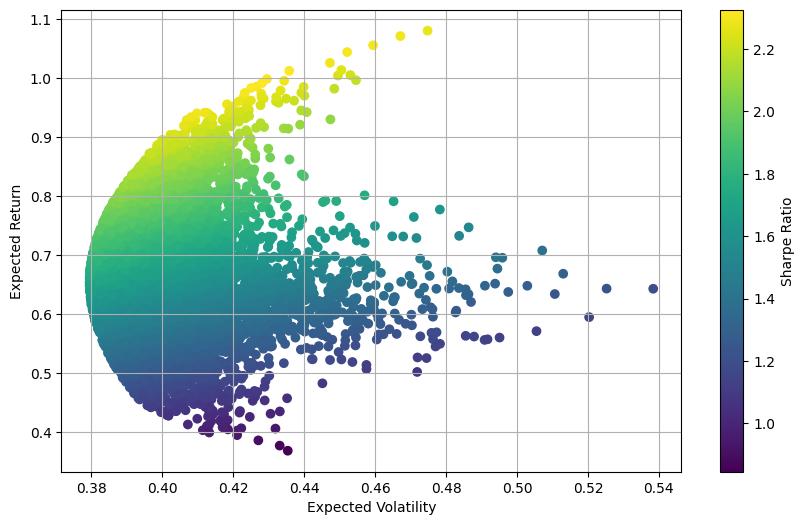

Optimal portfolio:  [0.142 0.786 0.    0.072]
Expected return, volatility and Sharpe ratio:  [1.0190439  0.43685556 2.33267925]
TSLA: 2839.9999999999995
NVDA: 15720.0
AMD: 0.0
SHOP: 1440.0
Expected return: 1.0190438971110924
Expected volatility: 0.4368555593123723
Sharpe ratio: 2.332679246923416


In [62]:
stocks=filter_valid_tickers(stocks)
print(stocks)

dataset = download_data(stocks,start_date,end_date)
show_data(dataset)
print(dataset)
log_daily_returns = calculate_return(dataset)
# show_statistics(log_daily_returns)

pweights, means, risks = generate_portfolios(log_daily_returns)
show_portfolios(means, risks)
optimum = optimize_portfolio(pweights, log_daily_returns)
weights=[]
stats=[]
print_optimal_portfolio(optimum, log_daily_returns,weights,stats,capital)
#show_optimal_portfolio(optimum, log_daily_returns, means, risks)